In [389]:
from matplotlib import image
from matplotlib import pyplot as plt

In [390]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import xarray as xr
import rioxarray as rxr
import earthpy as et
import earthpy.plot as ep

In [391]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [392]:
from sklearn.neighbors import KNeighborsClassifier


In [393]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr

In [394]:
import random

In [395]:
from tqdm import tqdm

In [396]:
import pandas as pd

In [397]:
from sklearn import model_selection, metrics

In [398]:
%run technical_functions/cv_and_reclassification_methods.ipynb

In [12]:
%run technical_functions/functions_geotransforms.ipynb

Попробуем отклассифицировать тензор признаков CDTM-матрицы.

In [433]:
T = np.load('properties_55/CDTM_properties_55.npy')

In [434]:
T[:,:,1]

array([[ 63.8027467 ,  64.5344383 ,  66.43752397, ..., 185.7854921 ,
        186.16682343, 186.65801046],
       [ 60.9472259 ,  61.73980793,  63.81636716, ..., 186.58410245,
        186.32649945, 186.78368621],
       [ 56.79486918,  58.56104757,  61.2892562 , ..., 186.1592866 ,
        184.97726595, 184.07751081],
       ...,
       [220.97887815, 214.90220111, 213.75727597, ..., 172.43828594,
        172.99112356, 171.7254779 ],
       [219.62729731, 212.85880909, 211.62960365, ..., 163.90876873,
        163.60128472, 160.93939238],
       [220.97932348, 213.70009583, 211.99439142, ..., 158.81289699,
        158.24846237, 155.08937831]])

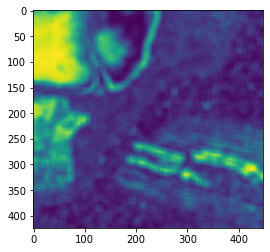

In [435]:
plt.imshow(T[:, :, 3
            ])

In [436]:
np.count_nonzero(np.isnan(T))

0

Загружаем карту.

In [437]:
map_konst = gdal.Open('Konstantinovsky_map.tif')
konstantinovsky_mult = rxr.open_rasterio("geotiff/Konstantinovky_TestReg_mult.tif")
konstantinovsky_mult_gdal = gdal.Open("geotiff/Konstantinovky_TestReg_mult.tif")
map_konst_rasterio = rxr.open_rasterio("Konstantinovsky_map.tif").squeeze()
m_m, m_n = konstantinovsky_mult.shape[1], konstantinovsky_mult.shape[2]
geo_trans_mult = konstantinovsky_mult_gdal.GetGeoTransform()
proj_mult = konstantinovsky_mult_gdal.GetProjection()
geo_trans_pan = map_konst.GetGeoTransform()
proj_pan = map_konst.GetProjection()
pixels_pan_list = []
for i in range(1, m_m + 1):
    a = []
    for j in range(1, m_n + 1):
        a.append((i, j))
    a_coords = pix2coord(a, geo_trans_mult, proj_mult) #были пиксели в мультиканальном, стали координаты
    a_pixels_in_pan = coord2pix(a_coords, geo_trans_pan, proj_pan)
    pixels_pan_list.append(a_pixels_in_pan)
map_konst_ = np.zeros((T.shape[0], T.shape[1]))
cnt_i = 0
cnt_j = 0
for line in tqdm(pixels_pan_list):
    cnt_j = 0
    for elem in line:
        i, j = elem
        i = int(i - 1)
        j = int(j - 1)
        map_konst_[cnt_i][cnt_j] = map_konst_rasterio.values[i][j]
        cnt_j += 1
    cnt_i += 1

100%|███████████████████████████████████████████████████████████████████████████████| 424/424 [00:02<00:00, 149.95it/s]


In [438]:
map_konst_.shape

(424, 448)

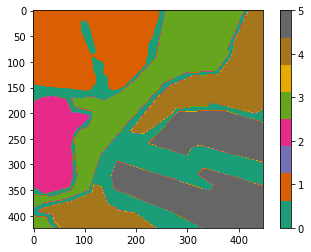

In [439]:
plt.imshow(map_konst_, cmap=plt.get_cmap('Dark2'))
plt.colorbar()

In [440]:
import skimage.io
import skimage.filters

sigma = 7.0
for i in range(5):
    T[:, :, i] = skimage.filters.gaussian(
        T[:, :, i], sigma=(sigma, sigma), truncate=3.5, multichannel=False)

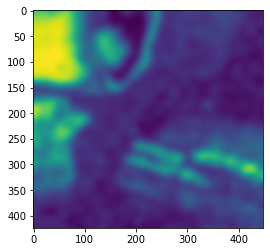

In [441]:
plt.imshow(T[:, :, 3])

In [442]:
from sklearn.preprocessing import StandardScaler
T = T.reshape((T.shape[0] * T.shape[1], 5))
scaler = StandardScaler()
T = scaler.fit_transform(T)

In [443]:
map_konst_ = map_konst_.reshape((map_konst_.shape[0] * map_konst_.shape[1], 1))

In [444]:
T.shape

(189952, 5)

In [445]:
map_konst_.shape

(189952, 1)

In [446]:
data = np.concatenate((T, map_konst_), axis = 1)

In [447]:
data.shape

(189952, 6)

In [448]:
map_konst_.shape

(189952, 1)

In [449]:
np.count_nonzero(map_konst_ == 2)

14465

In [450]:
import random

In [451]:
ones = data[np.argwhere(map_konst_.squeeze() == 1), :].squeeze()
data_ = np.array(random.sample(list(ones), 10000))
for i in range(2, 6):
    tmp = data[np.argwhere(map_konst_.squeeze() == i), :].squeeze()
    data_ = np.concatenate((data_, np.array(random.sample(list(tmp), 13000))), axis = 0)

In [452]:
data_.shape

(62000, 6)

In [453]:
X = data_[:, :5]
y = data_[:, 5]

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=0, stratify = y)

In [455]:
qda = QuadraticDiscriminantAnalysis()

In [456]:
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

In [457]:
pred_qda = qda.predict(T)

In [458]:
pred_qda

array([1., 1., 1., ..., 5., 5., 5.])

In [459]:
p = pred_qda.reshape((424, 448))

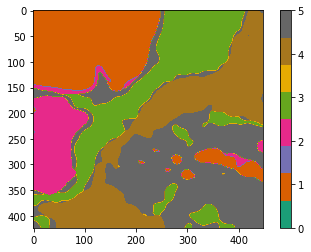

In [460]:
plt.imshow(p, cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()

In [461]:
from sklearn.neighbors import KNeighborsClassifier

In [462]:
knn = KNeighborsClassifier(n_neighbors = 7)

In [463]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [464]:
pred_knn = knn.predict(T).reshape((424, 448))

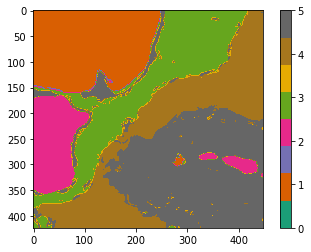

In [465]:
plt.imshow(pred_knn, cmap=plt.get_cmap('Dark2'), vmin=0, vmax=5)
plt.colorbar()